# Google Play Store 리뷰 크롤링을 통한 데이터 분석

- 목적 : 어플리케이션 리뷰를 분석하여 인사이트 도출
- 대상 : Naver Vibe 어플리케이션
- 데이터 수집방법 : Google Play Store 리뷰 크롤링
- 데이터 
    - 기간 : 2019년 1월 1일 ~ 2020년 3월 21일
    - 갯수 : 6360개
- 미리 크롤링 해놓은 json파일을 이용해 데이터를 불러와서 분석 진행

## 1. 필요한 Module Import 하기

In [1]:
import pandas as pd
import re
from bs4 import BeautifulSoup
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'AppleGothic' # 글씨체
from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
import warnings
import numpy as np

warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 2. 크롤링 해놓은 파일 Load 및 전처리

In [2]:
df = pd.read_json("./data/vibe_year.json")

p = re.compile(r'\d+') # 숫자만 들고와
def parser(body):
    bs = BeautifulSoup(body, 'html.parser')
    date = bs.find('span', class_='p2TkOb').text
    rating = bs.find('div', {'role':'img'})['aria-label']
    rating = p.findall(rating)[-1]
    review_text = bs.find('span', {'jsname':'bN97Pc'}).text
    return date, int(rating), review_text

In [3]:
df['date'], df['rating'], df['review_text'] = zip(*df['body'].map(parser))
df['date'] = pd.to_datetime(df['date'], format='%Y년 %m월 %d일') # convert to datetime format
df['month'] = df['date'].apply(lambda x: x.strftime('%Y%m')) # add month data
del df['body']
df.drop(df[df['date'] < datetime(2019, 1, 1)].index, inplace=True) # 2020년도 data만 사용

- 크롤링 해온 json파일을 불러와 핸들링 할 수 있게끔, DataFrame 형태로 만들어 준다.
- 크롤링 한 정보 중 날짜, 별점, 리뷰 정보를 사용한다.
- Month 정보를 새로운 컬럼에 저장해준다.

In [4]:
# review 전처리
df = df.dropna(how = 'any') # Null 값이 존재하는 행 제거
df['review_text'] = df['review_text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식을 통한 한글 외 문자 제거
df['review_text'] = df['review_text'].map(lambda x : x.strip()) # 스페이스 공백으로 채워져있는 있는 내용 제거 
df = df[df['review_text'] != ''] # 위에서 한글 외 문자 제거를 하면서 ''인 내용들이 생기거나 원래 ''인 내용들 제거

- 리뷰 항목을 쓰기 좋게 전처리 해준다.

In [5]:
df.head()

,date,rating,review_text,month
0,2020-03-11,2,정말 아티스트 수익 분배 방식 네이버 뮤직에서만 이용가능한 다이렉트 곡들등등 장점이...,202003
1,2020-03-11,2,전 따로 플레이리스트를 만들지 않습니다 그래서 이어지는 노래에서 선택한 곡이나 그룹...,202003
2,2020-03-07,3,불편한점이 정말 많네요 첫번째로는 저는 플레이리스트를 자주 바꿔주는편인데 플레이중인...,202003
3,2020-03-17,2,왜 다들 인터페이스 별로라고 하는지 몰랐는데 설치 후 음악 추가하면서 바로 느낌ㅎ ...,202003
4,2020-03-21,5,점주고 십어요 ㅠㅠ 진짜 무료 노래도 띵곡들이 많고 돈도 많이 않들고 ㅠㅠ 진짜 이...,202003


## 3. 데이터 탐색하기

### 3-1. 월별 < 리뷰 수 > 비교

Text(0.5, 0.98, '월 별 <리뷰 수> 비교')

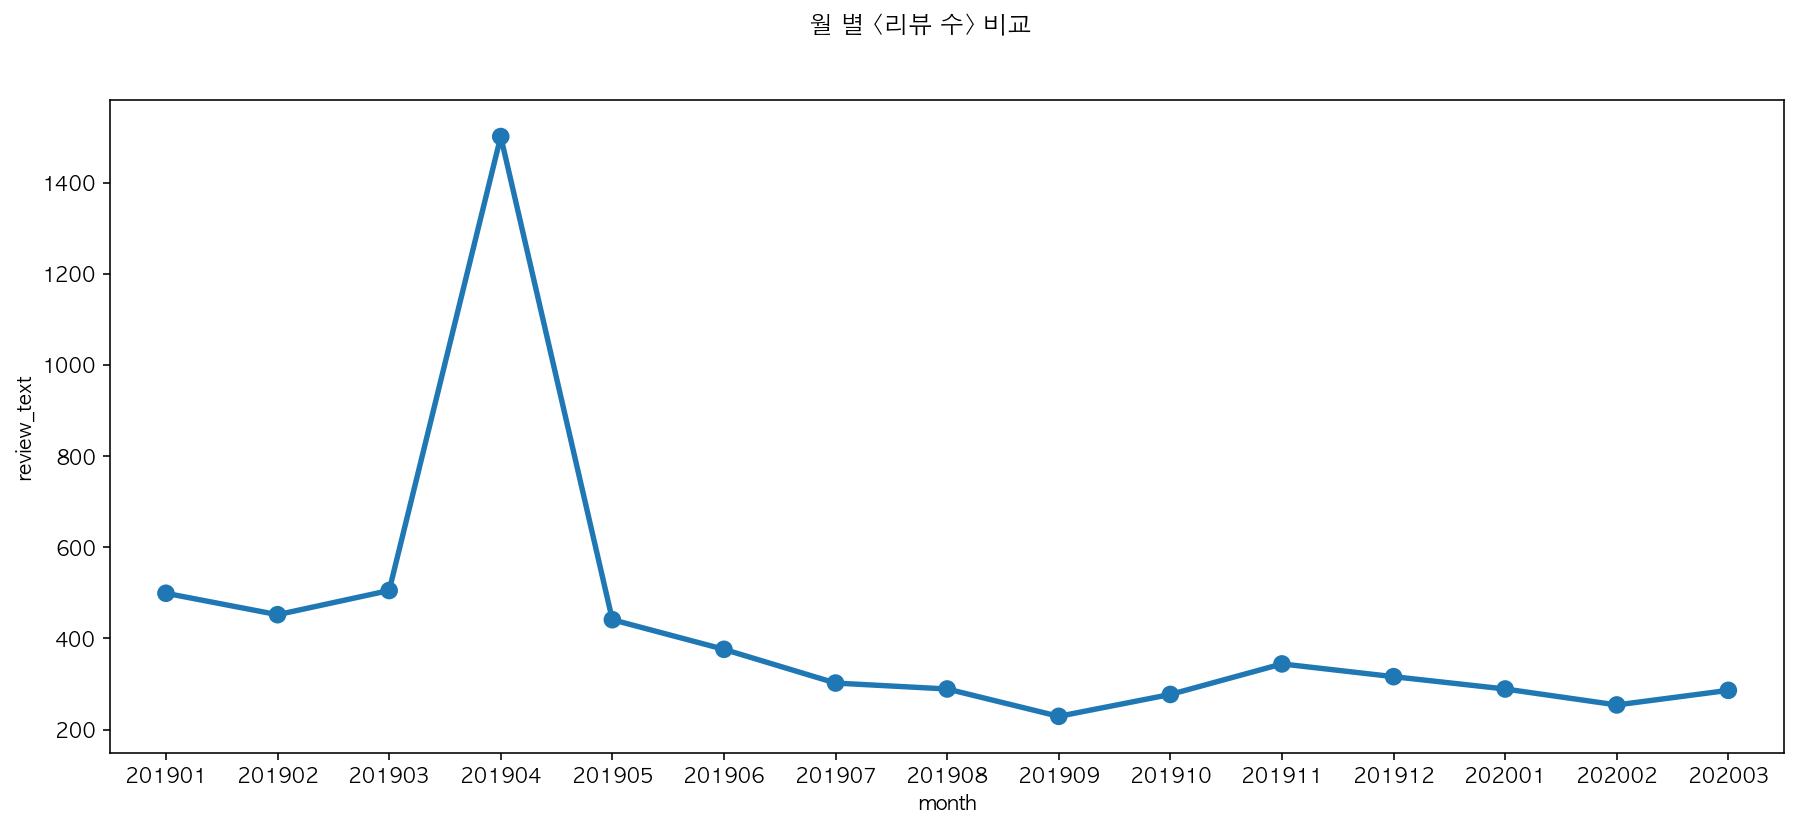

In [6]:
plt.figure(figsize=(15, 6))
t1 = pd.pivot_table(data=df, index=['month'], values='review_text', aggfunc='count').reset_index()
sns.pointplot(data=t1, x='month', y='review_text')
plt.suptitle('월 별 <리뷰 수> 비교')

- 월별로 데이터를 분석한 결과 2019년 4월에 댓글 수가 급격히 많은 것을 확인 할 수 있다.
- 조금 더 자세히 살펴보기 위해 4월의 데이터만 날짜별로 리뷰수를 확인해보자

In [7]:
df_april = df[(df['date'] >= datetime(2019,4,1)) & (df['date'] < datetime(2019,5,1))]

        date  review_text
3 2019-04-04          118


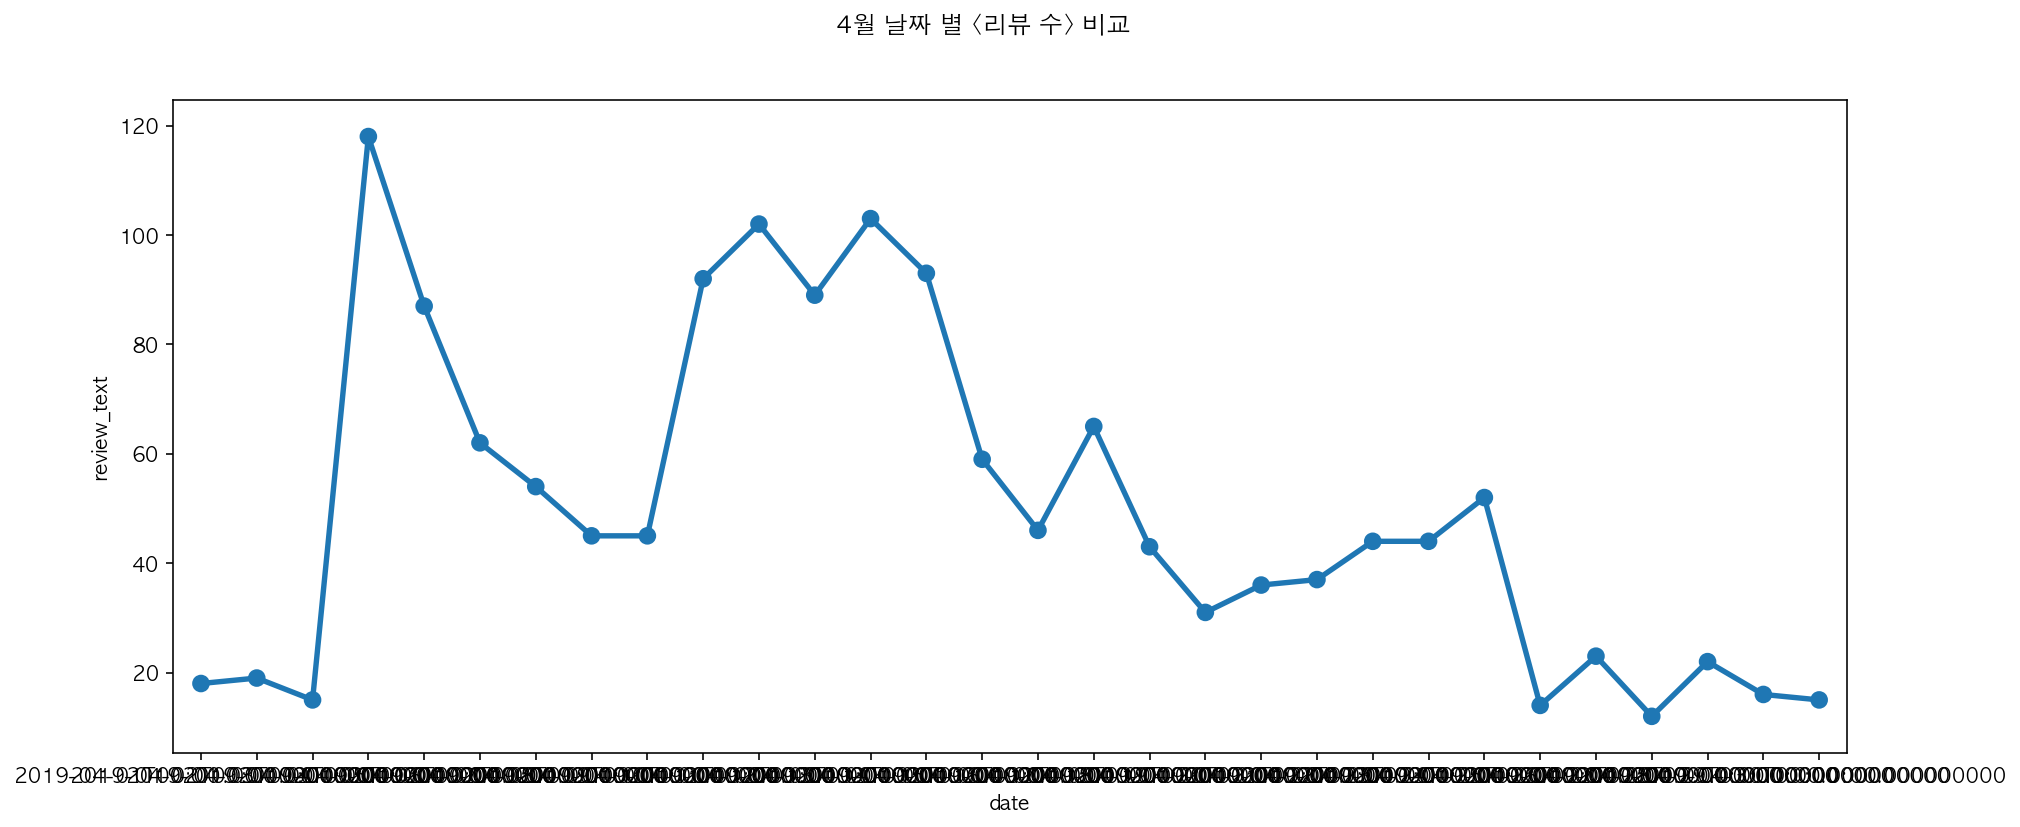

In [8]:
plt.figure(figsize=(15, 6))
t1 = pd.pivot_table(data=df_april, index=['date'], values='review_text', aggfunc='count').reset_index()
sns.pointplot(data=t1, x='date', y='review_text')
plt.suptitle('4월 날짜 별 <리뷰 수> 비교')
print(t1[t1['review_text'] > 110])

- 4월 4일을 기점으로 리뷰 수가 급격히 증가하는 것을 볼 수 있다. 
- 2019년 4월의 리뷰의 별점의 분포가 어떤지 살펴보자.

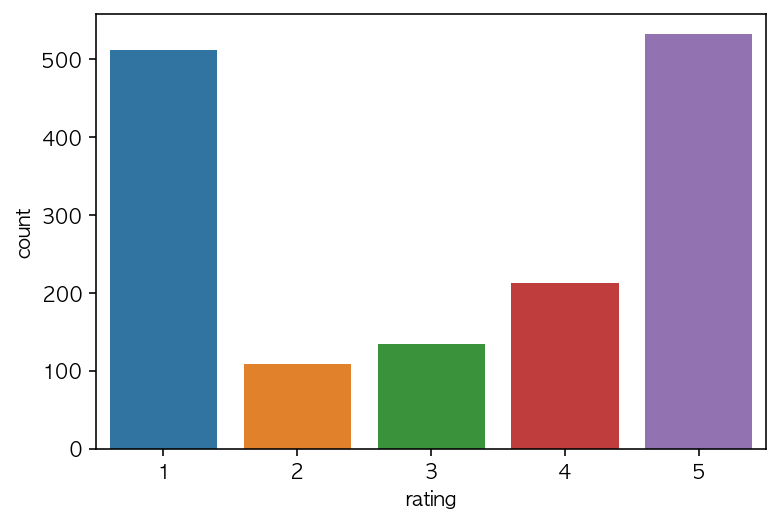

In [9]:
sns.countplot(data=df_april, x='rating')

- 1점과 5점의 별점 수가 다른 별점에 비해 월등이 많은 것을 확인 할 수 있다.
- 2019년 4월의 리뷰를 낮은 별점(1,2점)과 높은 별점(4,5점)으로 나누어 어떤 단어가 많이 등장 했는지 WordCloud를 통해 확인해보자.

In [10]:
df_april_low_rating = df_april[(df_april['rating'] == 1) | (df_april['rating'] == 2)]
df_april_high_rating = df_april[(df_april['rating'] == 4) | (df_april['rating'] == 5)]

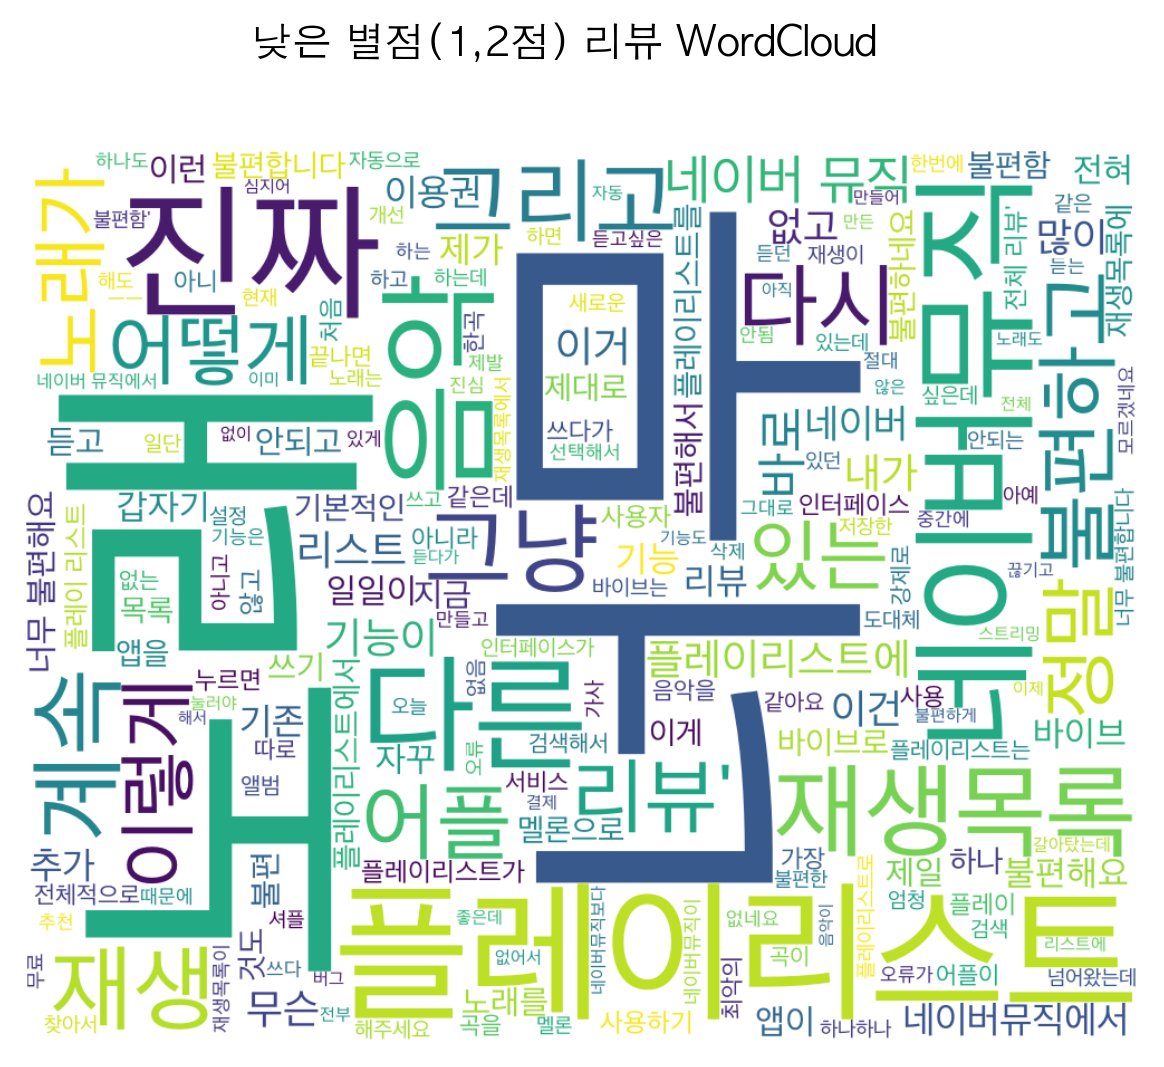

In [11]:
font_path = '/System/Library/Fonts/AppleSDGothicNeo.ttc'
wc = WordCloud(width = 1000, height = 800, background_color="white", font_path=font_path).generate(np.array2string(df_april_low_rating['review_text'].values))
plt.figure(figsize=(6, 5), dpi=120)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.suptitle('낮은 별점(1,2점) 리뷰 WordCloud')
plt.show()

- 플레이리스트 관련 이슈와 네이버뮤직과 관련한 이슈가 주된 내용으로 보인다.

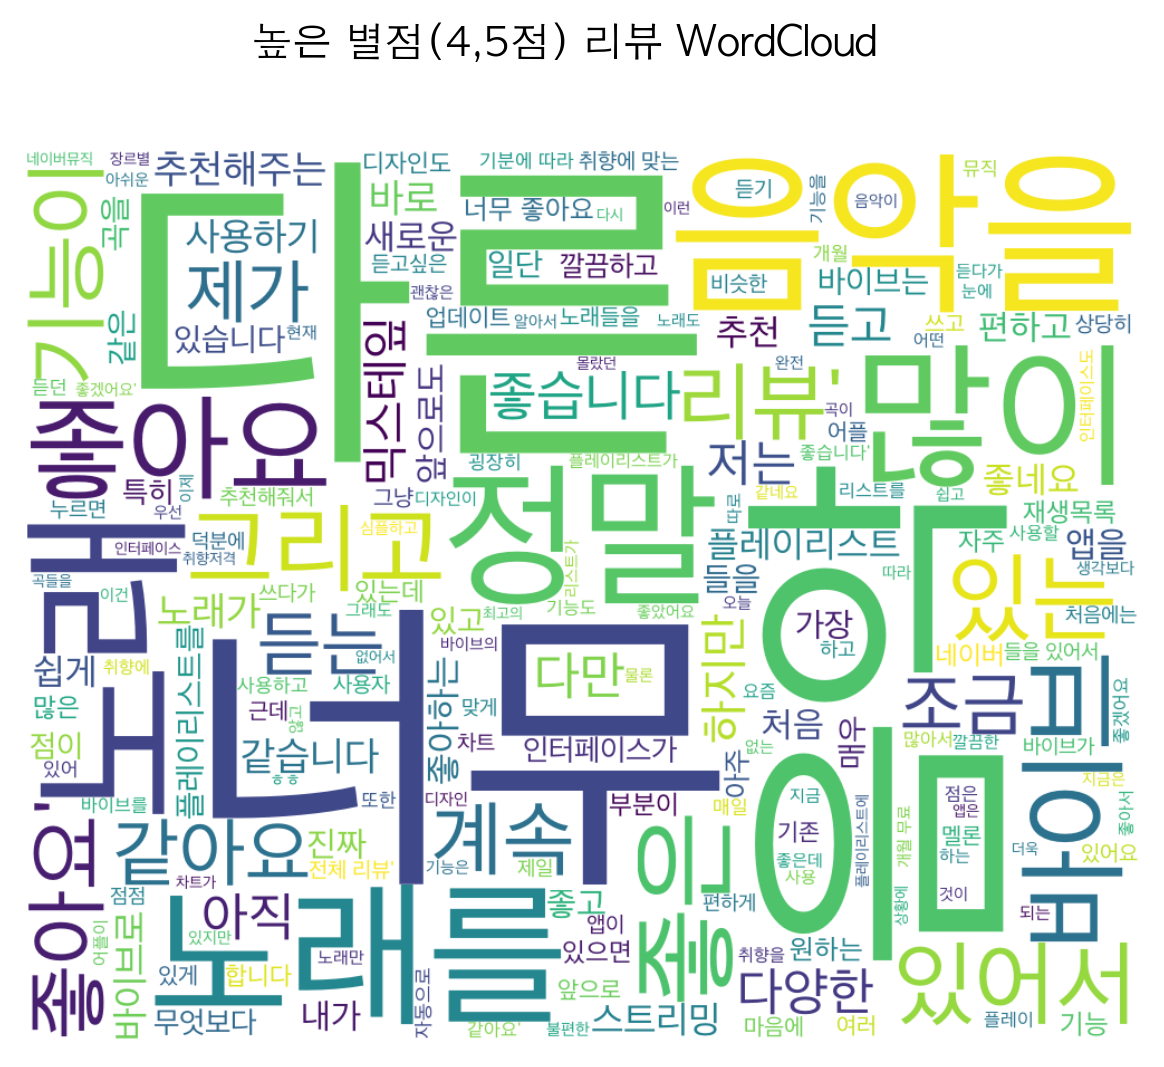

In [12]:
font_path = '/System/Library/Fonts/AppleSDGothicNeo.ttc'
wc = WordCloud(width = 1000, height = 800, background_color="white", font_path=font_path).generate(np.array2string(df_april_high_rating['review_text'].values))
plt.figure(figsize=(6, 5), dpi=120)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.suptitle('높은 별점(4,5점) 리뷰 WordCloud')
plt.show()

- 대체로 다른 스트리밍 어플과 비교해서 좋다는 내용이 많아 보인다.
- 4월이 아닌 다른 기간의 주위 데이터들과 비교해보자. (3, 5월 데이터이용)

In [13]:
df_march_may = df[(df['month'] == '2019.3') | (df['date'] == '2019.5')]

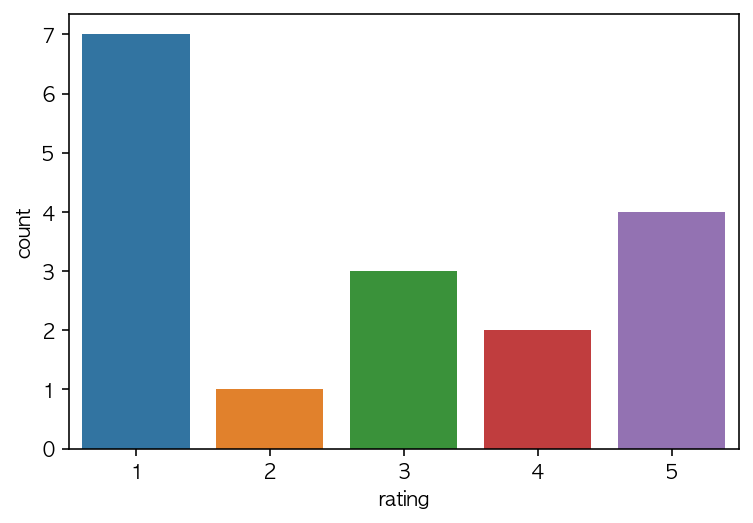

In [14]:
sns.countplot(data=df_march_may, x='rating')

- 2019년 3월과 5월은 별점 1점이 굉장히 많다.

In [15]:
df_march_may_low_rating = df_april[(df_april['rating'] == 1) | (df_april['rating'] == 2)]
df_march_may_high_rating = df_april[(df_april['rating'] == 4) | (df_april['rating'] == 5)]

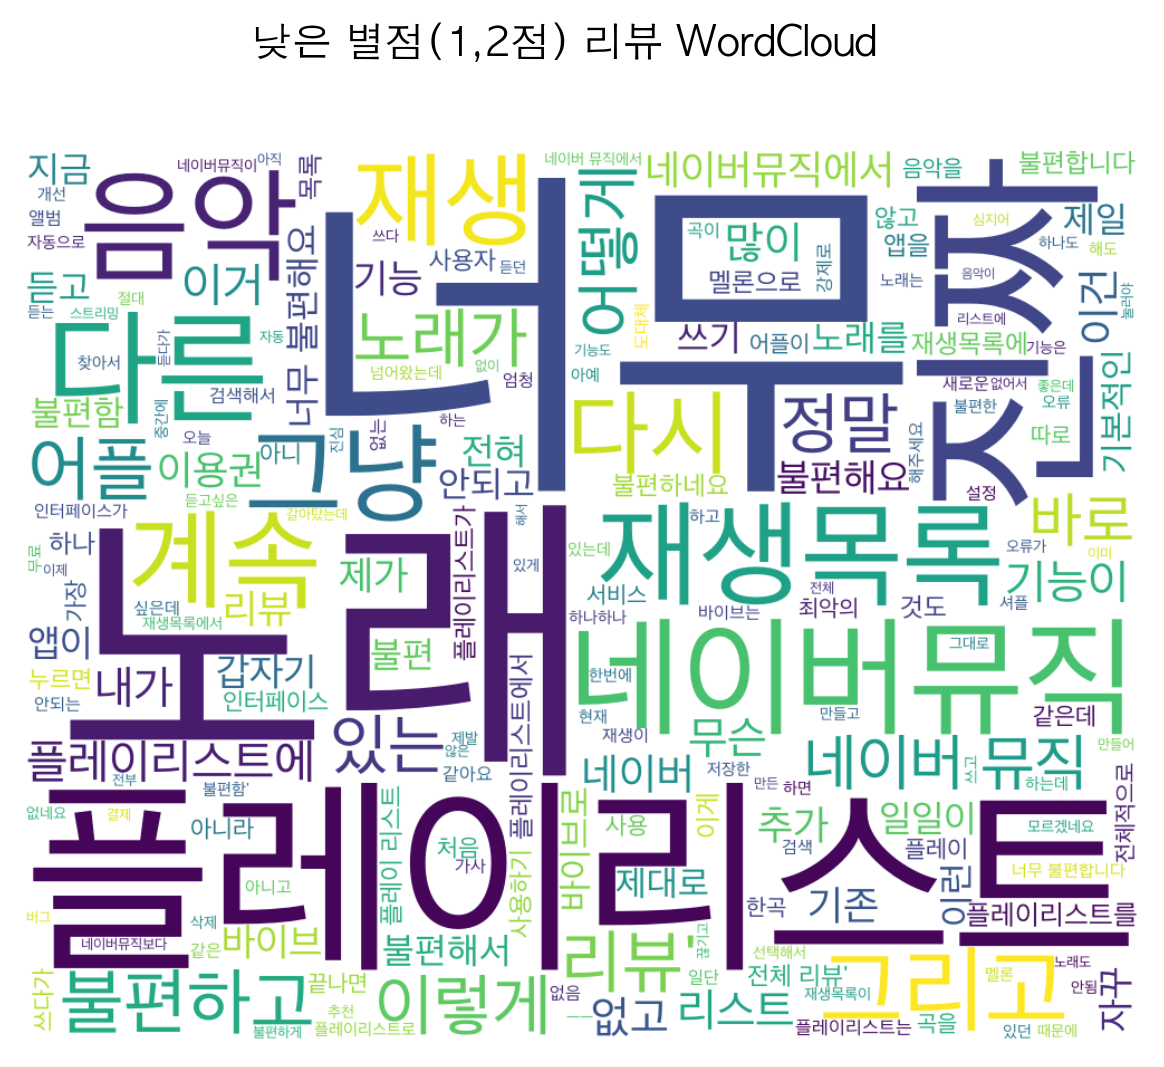

In [16]:
font_path = '/System/Library/Fonts/AppleSDGothicNeo.ttc'
wc = WordCloud(width = 1000, height = 800, background_color="white", font_path=font_path).generate(np.array2string(df_march_may_low_rating['review_text'].values))
plt.figure(figsize=(6, 5), dpi=120)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.suptitle('낮은 별점(1,2점) 리뷰 WordCloud')
plt.show()

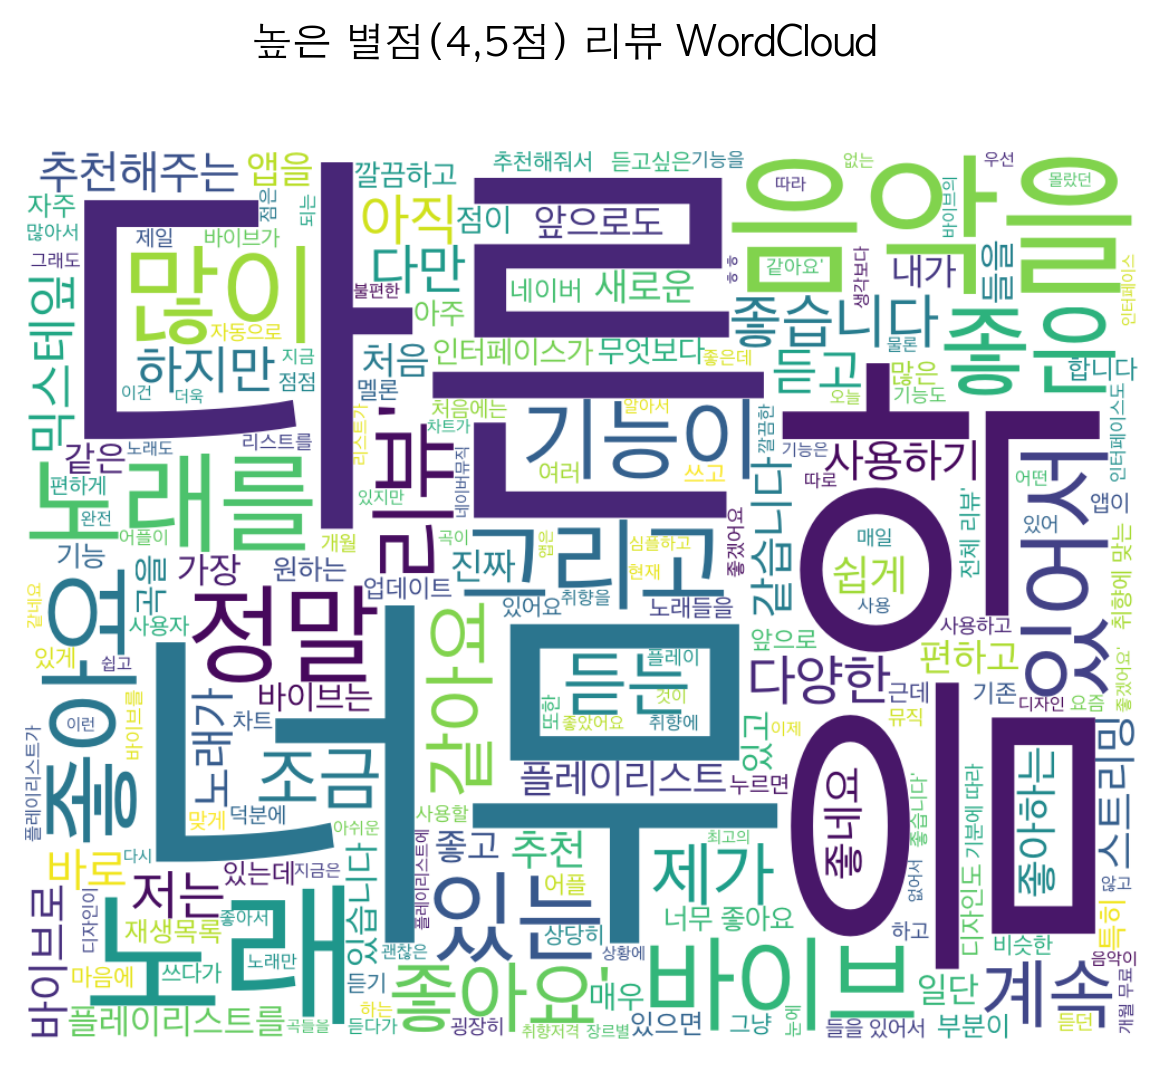

In [17]:
font_path = '/System/Library/Fonts/AppleSDGothicNeo.ttc'
wc = WordCloud(width = 1000, height = 800, background_color="white", font_path=font_path).generate(np.array2string(df_march_may_high_rating['review_text'].values))
plt.figure(figsize=(6, 5), dpi=120)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.suptitle('높은 별점(4,5점) 리뷰 WordCloud')
plt.show()

- 4월에 데이터와 비교해 봤을 때, 나온 단어들은 거의 변화가 없어 보인다.

- 지난 2019.3월, 4월을 기준으로 구글 검색을 진행해본 결과, Twitter에는 2019.3.21 포스팅, Facebook에는 2019.4.5 포스팅으로 대학생을 위한 3개월 무료 이용권 이벤트를 진행했음을 알 수 있었다.
- 따라서 기술적 이슈가 있었다기 보다는 이벤트 진행으로 이용자 수가 증가하면서 자연스레 댓글 수도 늘어난 것으로 예상된다.

### 3-2. 월 별 < 평균 평점 >  비교

Text(0.5, 0.98, '월 별 <평균 평점> 비교')

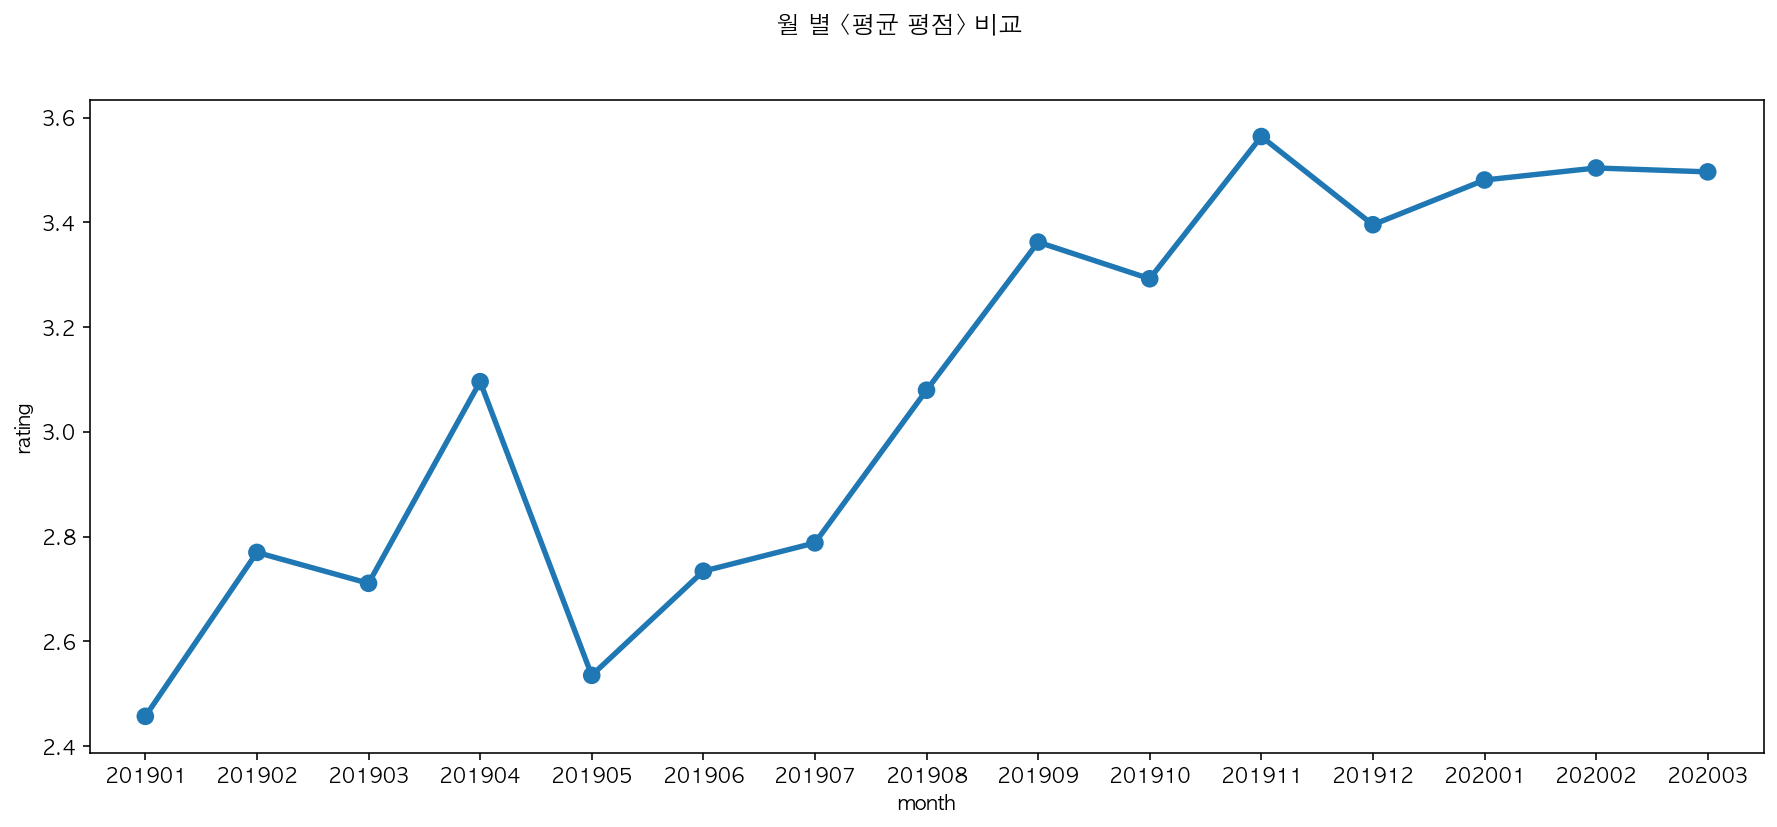

In [18]:
plt.figure(figsize=(15, 6))
t2 = pd.pivot_table(data=df, index=['month'], values='rating', aggfunc='mean').reset_index()
sns.pointplot(data=t2, x='month', y='rating')
plt.suptitle('월 별 <평균 평점> 비교')

- 2019년 4월을 제외(이벤트)하고, 1월~7월까지 2점 후반대의 별점을 기록하하다가 그 이후 점점 증가하는 추세를 확인할 수 있다.
- 가장 높은 평점을 받았던 2019.11와 가장 낮은 평점을 기록한 2019.1과 2019.5 별점 데이터의 분포를 확인해보자.
( 실제 가장 낮은 수치는 1월 )

In [19]:
df_nov = df[df['month'] == '201911']
df_jan = df[df['month'] == '201901']
df_may = df[df['month'] == '201905']

Text(0.5, 1.0, '201905')

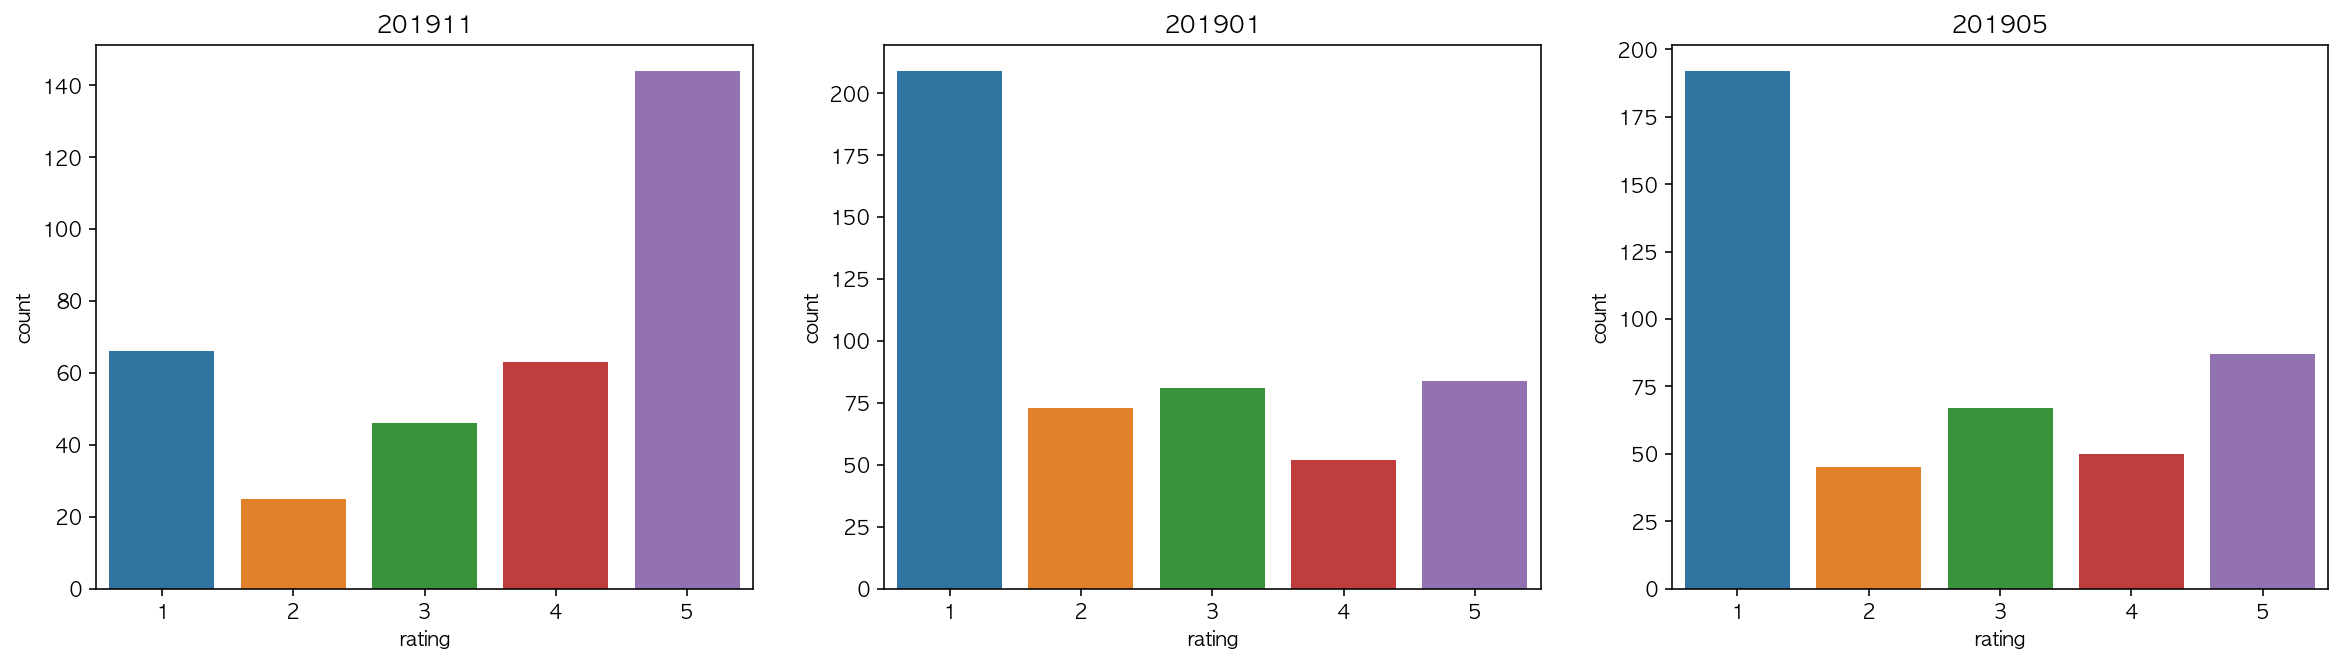

In [20]:
figure, ((ax1,ax2,ax3))= plt.subplots(nrows=1,ncols=3) 
figure.set_size_inches(20,5)

sns.countplot(data=df_nov, x='rating', ax=ax1).set_title("201911")
sns.countplot(data=df_jan, x='rating', ax=ax2).set_title("201901")
sns.countplot(data=df_may, x='rating', ax=ax3).set_title("201905")

- 당연한 결과로, 평점이 가장 높은 11월은 평점 5점이 가장 많고, 1월과 5월은 평점 1이 가장 많다.
- 3-1에서는 WordCloud를 활용했다. 이번에는 Sentence token화를 이용해 상위 10개의 단어를 출력해보자.

In [21]:
okt = Okt()

def get_word_low_rating(sentence):
    nouns = okt.nouns(sentence)
    return [noun for noun in nouns if len(noun) > 1]

def word_voca(sentence) : 
    countvector = CountVectorizer(tokenizer=get_word_low_rating, max_features=300)
    tdf = countvector.fit_transform(sentence)
    words = countvector.get_feature_names()
    count_mat = tdf.sum(axis=0)
    count = np.squeeze(np.asarray(count_mat))
    word_count = list(zip(words, count))
    word_count = sorted(word_count, key=lambda t:t[1], reverse=True)
    return word_count

In [22]:
nov_voca_pos = word_voca(df_nov[df_nov['rating'] == 5]['review_text'])[:5]
nov_voca_neg = word_voca(df_nov[df_nov['rating'] == 1]['review_text'])[:5]
jan_voca = word_voca(df_jan[df_jan['rating'] == 1]['review_text'])[:5]
may_voca = word_voca(df_may[df_may['rating'] == 1]['review_text'])[:5]

In [23]:
print('11월 별점 5점 상위 5개 단어 : ', nov_voca_pos)
print('11월 별점 1점 상위 5개 단어 : ', nov_voca_neg)
print('5월 별점 1점 상위 5개 단어 : ', jan_voca)
print('1월 별점 1점 상위 5개 단어 : ', may_voca)

11월 별점 5점 상위 5개 단어 :  [('노래', 29), ('음악', 14), ('바이브', 13), ('사용', 13), ('정말', 12)]
11월 별점 1점 상위 5개 단어 :  [('네이버', 23), ('뮤직', 19), ('재생', 18), ('노래', 16), ('기능', 12)]
5월 별점 1점 상위 5개 단어 :  [('뮤직', 136), ('네이버', 131), ('재생', 73), ('기능', 67), ('노래', 65)]
1월 별점 1점 상위 5개 단어 :  [('뮤직', 96), ('네이버', 91), ('재생', 68), ('노래', 59), ('플레이', 51)]


- 분석 결과 1월과 5월의 별점 1점은 네이버, 뮤직, 재생 관련이 가장 많았다.  
=> 대략적인 리뷰를 보았을 때 네이버 뮤직에서 Vibe로 넘어 온 사람들의 불만이 많았던 것으로 보였다.
- 가장 별점이 높았던 11월의 1점 데이터와 비교해 보았을 때, 크게 달라진 부분이 없었다.  
=> 1월, 5월과 사유는 비슷하지만 그 비율이 줄어든 것으로 판단된다.
- 11월의 5점 데이터와 비교해 보면, '바이브'라는 어플리케이션 이름이 직접 들어가 있는 특징을 나타내고 있다.

## 4. 종합

- 리뷰, 평점, 날짜라는 Feature를 가지고 간단한 데이터 탐색과정을 진행해 보았다.
- 월별 리뷰수를 비교해 본 결과 2019년 4월의 리뷰 수가 가장 많았으며, 그 이유는 이벤트 때문이라고 볼 수 있다.
- 월별 평균평점을 보면, 2019년 7월까지는 2점 대 후반 근처였다가 점점 증가해 현재는 3점대 중반 평점을 가지고 있다.
- 낮은 평점을 주는 사람들의 리뷰에는 네이버, 뮤직이라는 단어가 많이 등장하는 것을 알 수 있다.